<a href="https://colab.research.google.com/github/hieupc02/Twitter-Sentiment-Analysis-Using-CNN_NLP/blob/main/Twitter_Sentiment_Analysis_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/eyaler/word2vec-slim/raw/master/GoogleNews-vectors-negative300-SLIM.bin.gz
!gunzip GoogleNews-vectors-negative300-SLIM.bin.gz

--2023-03-16 02:38:55--  https://github.com/eyaler/word2vec-slim/raw/master/GoogleNews-vectors-negative300-SLIM.bin.gz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/eyaler/word2vec-slim/master/GoogleNews-vectors-negative300-SLIM.bin.gz [following]
--2023-03-16 02:38:56--  https://media.githubusercontent.com/media/eyaler/word2vec-slim/master/GoogleNews-vectors-negative300-SLIM.bin.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276467217 (264M) [application/octet-stream]
Saving to: ‘GoogleNews-vectors-negative300-SLIM.bin.gz’

GoogleNews-vectors- 100%[===================>

In [2]:
import numpy as np
import pandas as pd

# This is for making some large tweets to be displayed
pd.options.display.max_colwidth = 100

# I got some encoding issue, I didn't knew which one to use !
# This post suggested an encoding that worked!
#https://stackoverflow.com/questions/19699367/unicodedecodeerror-utf-8-codec-cant-decode-byte
train_data = pd.read_csv("/content/train.csv", encoding='ISO-8859-1',)

In [3]:
train_data

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL friend.............
1,2,0,I missed the New Moon trailer...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2...
4,5,0,i think mi bf is cheating on me!!! T_T
...,...,...,...
99984,99996,0,@Cupcake seems like a repeating problem hope you're able to find something.
99985,99997,1,"@cupcake__ arrrr we both replied to each other over different tweets at the same time , i'll se..."
99986,99998,0,@CuPcAkE_2120 ya i thought so
99987,99999,1,@Cupcake_Dollie Yes. Yes. I'm glad you had more fun with me.


In [4]:
from gensim.models import KeyedVectors

embed = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300-SLIM.bin', binary=True)

In [5]:
# Get the vocabulary used by the embedding

# dictionary for efficient search
embed_vocab = {}
for word in embed.vocab:
    embed_vocab[word] = True

In [6]:
tweets = train_data['SentimentText']
tweets_words = []
tweets_vocab = {}
for tweet in tweets:
    # Don't include words that can't actually be mapped to a vector using embeddings
    words = tweet.split()
    filtered_words = []
    for word in words:
        tweets_vocab[word] = True
        if embed_vocab.get(word) is not None:
            filtered_words.append(word)
    tweets_words.append(filtered_words)

In [7]:
# We check how many words from the dataset's vocabulary
# are found in the embedding vocab

def vocab_coverage(compared, base):
    hit, miss = 0, 0
    for word in compared:
        if base.get(word) is not None:
            hit += 1
        else:
            miss += 1

    print("{} words were found".format(hit))
    print("{} words weren't found".format(miss))
    
vocab_coverage(tweets_vocab, embed_vocab)

33676 words were found
150015 words weren't found


Counter({5: 7170, 4: 7157, 6: 6788, 7: 6511, 3: 6390, 8: 5958, 9: 5788, 10: 5363, 2: 5277, 11: 5042, 12: 4781, 13: 4464, 14: 4107, 15: 3901, 16: 3753, 1: 3407, 17: 3199, 18: 2756, 19: 2140, 0: 1957, 20: 1550, 21: 1052, 22: 654, 23: 426, 24: 231, 25: 83, 26: 44, 27: 26, 28: 6, 29: 5, 80: 1, 40: 1, 30: 1})


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

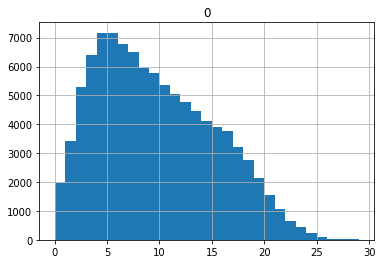

In [8]:
# We check the distribution of length of tweets after word filtering
from collections import Counter

len_counts = Counter([len(tweet) for tweet in tweets_words])

print(len_counts)
pd.DataFrame([len(tweet) for tweet in tweets_words]).hist(bins=list(range(30)))

In [9]:
tweets_words_idx = []
for tweet in tweets_words:
    indexs = []
    for word in tweet:
        idx = embed.vocab[word].index
        indexs.append(idx)
    tweets_words_idx.append(indexs)

print("An example tweet: {}".format(tweets_words_idx[0]))

An example tweet: [3, 80, 3949, 1, 119, 43610]


In [10]:
all_labels = np.array(train_data['Sentiment'])
def prepare_data(all_tweets, all_labels, max_words):
    labels = []
    tweets = []
    for i in range(len(all_tweets)):
        tweet = all_tweets[i]
        if not tweet:
            continue
        diff = max_words - len(tweet)
        if diff > 0: # need to pad
            tweet = [0 for j in range(diff)] + tweet
        elif diff < 0:
            tweet = tweet[: max_words]
        tweets.append(tweet)
        labels.append(all_labels[i])
    return (np.array(tweets), np.array(labels))

tweets, labels = prepare_data(tweets_words_idx, all_labels, 20)
assert len(tweets) == len(labels)
        

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Split train/val/test
import random

# to reproduce
random.seed(73)

ds_size = len(tweets)
train_ds_ratio = 0.7
idxs = list(range(ds_size))
random.shuffle(idxs)

end_train = int(ds_size * 0.7)
train_idxs = idxs[:end_train]
remaining_idxs = idxs[end_train:]
test_end = int(len(remaining_idxs) * 0.5)
test_idxs = remaining_idxs[:test_end]
val_idxs = remaining_idxs[test_end:]

train_data, train_label = tweets[train_idxs], labels[train_idxs]
test_data, test_label = tweets[test_idxs], labels[test_idxs]
val_data, val_label = tweets[val_idxs], labels[val_idxs]

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

datasets = {
    'train': TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_label)),
    'val': TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_label)),
    'test': TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_label)),
}

dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=batch_size),
    'val': DataLoader(datasets['val'], batch_size=batch_size),
    'test': DataLoader(datasets['test'], batch_size=batch_size),
}

# **Huấn luyện và đào tạo**


In [14]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [15]:
import torch.nn as nn
import torch.nn.functional as F

class SentimentCNN(nn.Module):
    """
    The embedding layer + CNN model that will be used to perform sentiment analysis.
    """

    def __init__(self, embed_model, vocab_size, output_size, embedding_dim,
                 num_filters=100, kernel_sizes=[3, 4, 5], freeze_embeddings=True, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentCNN, self).__init__()

        # set class vars
        self.num_filters = num_filters
        self.embedding_dim = embedding_dim
        
        # 1. embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # set weights to pre-trained
        self.embedding.weight = nn.Parameter(torch.from_numpy(embed_model.vectors)) # all vectors
        # (optional) freeze embedding weights
        if freeze_embeddings:
            self.embedding.requires_grad = False
        
        # 2. convolutional layers
        self.convs_1d = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embedding_dim), padding=(k-2, 0)) 
            for k in kernel_sizes])
        
        # 3. final, fully-connected layer for classification
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, output_size) 
        
        # 4. dropout and sigmoid layers
        self.dropout = nn.Dropout(drop_prob)
        self.sig = nn.Sigmoid()
        
    
    def conv_and_pool(self, x, conv):
        """
        Convolutional + max pooling layer
        """
        # squeeze last dim to get size: (batch_size, num_filters, conv_seq_length)
        # conv_seq_length will be ~ 200
        x = F.relu(conv(x)).squeeze(3)
        
        # 1D pool over conv_seq_length
        # squeeze to get size: (batch_size, num_filters)
        x_max = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x_max

    def forward(self, x):
        """
        Defines how a batch of inputs, x, passes through the model layers.
        Returns a single, sigmoid-activated class score as output.
        """
        # embedded vectors
        embeds = self.embedding(x) # (batch_size, seq_length, embedding_dim)
        # embeds.unsqueeze(1) creates a channel dimension that conv layers expect
        embeds = embeds.unsqueeze(1)
        
        # get output of each conv-pool layer
        conv_results = [self.conv_and_pool(embeds, conv) for conv in self.convs_1d]
        
        # concatenate results and add dropout
        x = torch.cat(conv_results, 1)
        x = self.dropout(x)
        
        # final logit
        logit = self.fc(x) 
        
        # sigmoid-activated --> a class score
        return self.sig(logit)

        

In [16]:
# Instantiate the model w/ hyperparams

vocab_size = len(embed_vocab)
output_size = 1 # binary class (1 or 0)
embedding_dim = len(embed['for']) # 300-dim vectors
num_filters = 100
kernel_sizes = [3, 4, 5]

net = SentimentCNN(embed, vocab_size, output_size, embedding_dim,
                   num_filters, kernel_sizes)

print(net)

SentimentCNN(
  (embedding): Embedding(299567, 300)
  (convs_1d): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1), padding=(1, 0))
    (1): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1), padding=(2, 0))
    (2): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1), padding=(3, 0))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sig): Sigmoid()
)


In [17]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# training loop
def train(net, train_loader, valid_loader, epochs, print_every=100):

    # move model to GPU, if available
    if(train_on_gpu):
        net.cuda()

    counter = 0 # for printing
    min_loss = np.Inf
    # train for some number of epochs
    net.train()
    for e in range(epochs):

        # batch loop
        for inputs, labels in train_loader:
            counter += 1

            if(train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()

            # zero accumulated gradients
            net.zero_grad()

            # get the output from the model
            output = net(inputs)

            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_losses = []
                net.eval()
                for inputs, labels in valid_loader:

                    if(train_on_gpu):
                        inputs, labels = inputs.cuda(), labels.cuda()

                    output = net(inputs)
                    val_loss = criterion(output.squeeze(), labels.float())

                    val_losses.append(val_loss.item())
                
                if np.mean(val_losses) < min_loss:
                    min_loss = np.mean(val_losses)
                    torch.save(net.state_dict(), "model.pth")
                    print("New val loss... saving model")
                
                net.train()
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))

In [26]:
# training params

epochs = 5 # this is approx where I noticed the validation loss stop decreasing
print_every = 500

train(net, dataloaders['train'], dataloaders['val'], epochs, print_every=print_every)

New val loss... saving model
Epoch: 1/5... Step: 500... Loss: 0.311315... Val Loss: 0.650898
New val loss... saving model
Epoch: 1/5... Step: 1000... Loss: 0.784586... Val Loss: 0.574761
Epoch: 2/5... Step: 1500... Loss: 0.276878... Val Loss: 0.754105
Epoch: 2/5... Step: 2000... Loss: 0.272420... Val Loss: 0.690113
Epoch: 3/5... Step: 2500... Loss: 0.225262... Val Loss: 0.883953
Epoch: 3/5... Step: 3000... Loss: 0.097962... Val Loss: 0.830467
Epoch: 4/5... Step: 3500... Loss: 0.223522... Val Loss: 0.983375
Epoch: 4/5... Step: 4000... Loss: 0.112720... Val Loss: 0.980194
Epoch: 5/5... Step: 4500... Loss: 0.075105... Val Loss: 1.308970
Epoch: 5/5... Step: 5000... Loss: 0.127307... Val Loss: 1.242924


In [27]:
net.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

# **Test**

In [28]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0


net.eval()
# lặp lại dữ liệu thử nghiệm
for inputs, labels in dataloaders['test']:

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
   # nhận kết quả đầu ra dự đoán
    output = net(inputs)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct / len(dataloaders['test'].dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.583
Test accuracy: 0.730


In [30]:
!git remote add origin https://github.com/hieupc02/Twitter-Sentiment-Analysis-Using-CNN_NLP.git
!git branch -M main 
!git push -u origin main

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
